In [ ]:
cd /Users/karolinegriesbach/Documents/Innkeepr/Git/evaluation-and-execution-scripts/

In [ ]:
import pandas as pd
import numpy as np
import awswrangler as wr
from matplotlib import pyplot as plt
import seaborn as sns

from general_functions.return_account_ids import return_account_ids
from general_functions.constants import return_api_url

In [ ]:
audience = "68b69fb82e5f2d9a58ce3439"
customer = "Tchibo"
date = "20260131"
url = return_api_url()
print(f"url = {url}")
account_id = return_account_ids()
account_id = [acc["id"] for acc in account_id if acc["name"] == customer]
account_id = account_id[0]

In [57]:
df = wr.s3.read_parquet(f"s3://{account_id}/targeting.history/{date}/{audience}.parquet")

In [58]:
df.columns

In [59]:
df["audience"].value_counts(dropna=False)

In [ ]:
df["treatment"].value_counts(dropna=False)
# caual: 68b69fe02e5f2d9a58ce5239
#03.01.2026: 3570854 (25.01 exkludiert)
#31.01.2026: 3537452 (25.01 exkludiert)
# conversions: 68b69fb82e5f2d9a58ce3439 (Innkeepr - Body - Likely Purchaser - Seed #2)
#03.01.2026: 3.877.832 (25.01 inkludiert)
#31.01.2026: 3.870.757 (25.01 inkludiert)

# conversions: 68b69fb82e5f2d9a58ce3439 (Innkeepr - Body - Likely Purchaser - Seed #2)
# 03.01.2026: 3.877.832 
# 31.01.2026: 3.870.757 

In [61]:
df["date"] = pd.to_datetime(df["session.date"]).dt.date
df["date"].value_counts().sort_index(ascending=False)

In [62]:
sys.exit()

In [ ]:
df.index[-int(len(df)*0.5)::], int(len(df)*0.5)

In [ ]:
if "new_treatment" in df.columns:
    df = df.drop(columns=["new_treatment"])
df = df.sort_values(by=["counterfactual"]).reset_index(drop=True)
df.loc[df.index[-int(len(df)*0.c):],"new_treatment"] = audience
df["new_treatment"] = df["new_treatment"].fillna("control")

In [ ]:
df.groupby("new_treatment")["counterfactual"].describe()

In [ ]:
df.groupby("treatment")["counterfactual"].describe()

In [ ]:
df['prev_treatment'] = df['treatment'].shift()
df['is_switch'] = df['treatment'] != df['prev_treatment']
index = df[df['is_switch']==True].index
print(f"index = {index}")
print(f"min_perc = {index[0]/len(df)}")
print(f"max_perc = {index[1]/len(df)}")


In [ ]:
sys.exit()

In [ ]:
df.sort_values(by="conv_prob", ascending=False)

In [ ]:
df["index"] = df.index
temp = df[["index","treatment"]]
temp["value"] = np.where(temp["treatment"] == audience, 2, 1)
sns.lineplot(data=temp, x="index", y="value", hue="treatment", marker="o")
temp

In [ ]:
date_count = pd.to_datetime(df["session.date"]).dt.date.value_counts().sort_index()
date_count.plot(x="session.date",y="count")
plt.xticks(rotation=90)
plt.grid(True)
plt.title(f"Targeting History {date}")

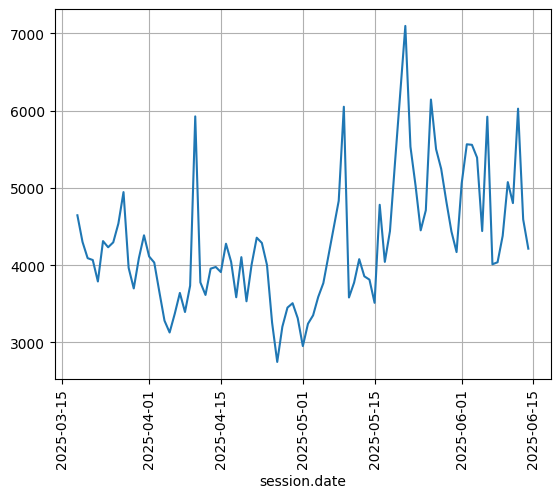

In [ ]:
df.groupby("treatment")["conv_prob"].describe().reset_index()

In [ ]:
conversion_probs = df.sort_values(by="session.date")
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.set_title(f"Conversion Probabilities of Audience {audience}")
ax = sns.lineplot(data=conversion_probs, x="session.date", y="conv_prob", hue="treatment", ax=ax)
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
fig.savefig(f"plot_{customer}_{audience}_conversion_probabilities_by_date.png")